[Sven Kreiss](https://www.svenkreiss.com/), 2019

# OpenPifPaf Prediction Demo

Programmatically use OpenPifPaf to run multi-person pose estimation on an image.

In [1]:
# Uncomment when using on Google Colab:
# !pip install --upgrade openpifpaf==0.10.1

In [2]:
%matplotlib inline

import io
import numpy as np
import openpifpaf
import PIL
import requests
import torch

device = torch.device('cpu')
# device = torch.device('cuda')  # if cuda is available

print(openpifpaf.__version__)
print(torch.__version__)

0.11rc1
1.3.1


## Load an Example Image and Display It

Image credit: "[Learning to surf](https://www.flickr.com/photos/fotologic/6038911779/in/photostream/)" by fotologic which is licensed under [CC-BY-2.0].

[CC-BY-2.0]: https://creativecommons.org/licenses/by/2.0/

In [3]:
image_response = requests.get('https://raw.githubusercontent.com/vita-epfl/openpifpaf/master/docs/coco/000000081988.jpg')
pil_im = PIL.Image.open(io.BytesIO(image_response.content)).convert('RGB')
im = np.asarray(pil_im)

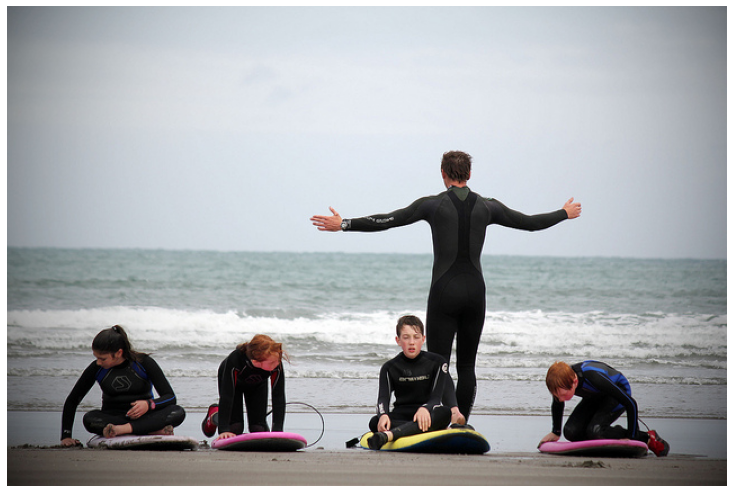

In [4]:
with openpifpaf.show.image_canvas(im) as ax:
  pass

## Load a Trained Neural Network

In [5]:
net_cpu, _ = openpifpaf.network.factory(checkpoint='shufflenetv2k18w')
net = net_cpu.to(device)

In [6]:
openpifpaf.decoder.CifSeeds.threshold = 0.5
openpifpaf.decoder.nms.Keypoints.keypoint_threshold = 0.3
openpifpaf.decoder.nms.Keypoints.instance_threshold = 0.2
processor = openpifpaf.decoder.factory_decode(net)

## Dataset, Dataloader, Visualizer, Prediction

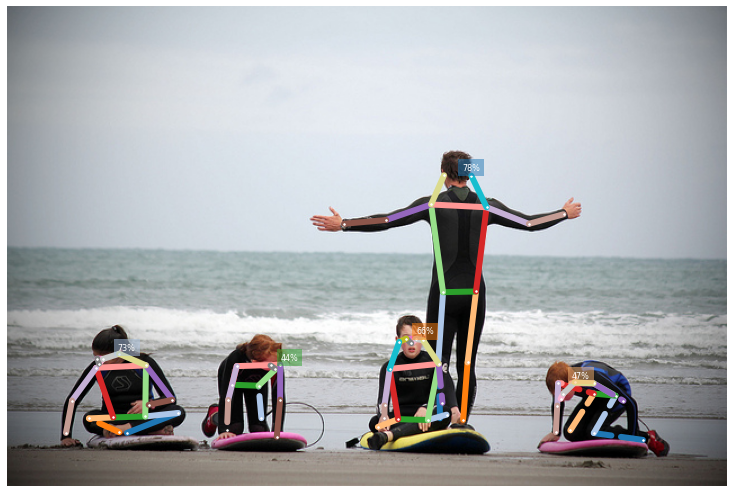

In [8]:
data = openpifpaf.datasets.PilImageList([pil_im])
loader = torch.utils.data.DataLoader(
  data, batch_size=1, pin_memory=True, 
  collate_fn=openpifpaf.datasets.collate_images_anns_meta)

keypoint_painter = openpifpaf.show.KeypointPainter(color_connections=True, linewidth=6)

for images_batch, _, __ in loader:
  predictions = processor.batch(net, images_batch, device=device)[0]
  with openpifpaf.show.image_canvas(im) as ax:
    keypoint_painter.annotations(ax, predictions)